In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.style.use('ggplot')

# Dataset overview

In [3]:
df = pd.read_pickle("data/preprocessed/collaborative_df.pkl")
df.sample(10)

,user_id,recipe_name,rating
246195,19775,484,5
2127989,166145,1579,5
1786193,139774,211,5
1551874,119794,1534,5
1195275,92602,502,5
184341,14998,1358,5
2163147,168693,150,5
149293,12219,355,5
1116379,86287,1202,5
982108,76384,2003,5


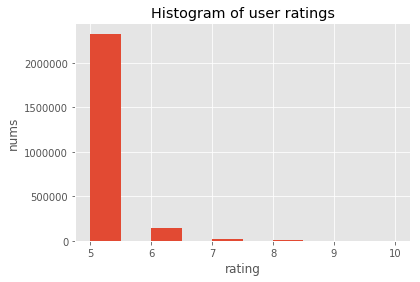

In [4]:
df.rating.hist()
plt.xlabel("rating")
plt.ylabel("nums")
plt.title("Histogram of user ratings");

In [5]:
print(f"Our dataset have {df.user_id.max()} unique users' favorite {len(df)} recipes in total.")
print(f"Recipes are mapped within {len(df.recipe_name.unique())} categories.")
print(f"User ratings are shown above, mean value is {df.rating.mean()}, maximum is {df.rating.max()}.")

Our dataset have 198816 unique users' favorite 2511218 recipes in total.
Recipes are mapped within 1628 categories.
User ratings are shown above, mean value is 5.091716051732665, maximum is 10.


# SVD algorithm

In [6]:
from surprise import dump
from surprise.accuracy import rmse

In [7]:
predictions_svd, algo_svd = dump.load('models/dump_SVD')
df_svd = pd.DataFrame(predictions_svd, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_svd = df_svd.rename(index=str, columns={"uid": "user_id", "iid": "item_id", "rui": "rating", "est": "estimation"}).drop("details", axis=1)

## Error analysis

In [8]:
df_svd['err'] = abs(df_svd.estimation - df_svd.rating)
df_svd.sample(10)

,user_id,item_id,rating,estimation,err
251645,20794,1086,5.0,4.997827,0.002173
166778,56889,294,5.0,5.144476,0.144476
752427,158969,622,5.0,5.076316,0.076316
763904,105710,1226,5.0,4.989100,0.010900
162796,76755,621,5.0,5.010914,0.010914
752750,118278,313,5.0,5.085399,0.085399
292889,137962,1344,5.0,4.982749,0.017251
171279,122470,33,5.0,4.961425,0.038575
424391,137549,107,5.0,4.917739,0.082261
750003,20353,1888,5.0,4.953488,0.046512


In [9]:
best_predictions = df_svd.sort_values(by='err')[:10]
worst_predictions = df_svd.sort_values(by='err')[-10:]

Prediction with the smallest error

In [10]:
best_predictions

,user_id,item_id,rating,estimation,err
345320,40272,1507,5.0,5.000000,5.729841e-08
313474,17419,1290,5.0,5.000000,1.080349e-07
32987,9058,1234,5.0,5.000000,1.850195e-07
137210,86430,1578,5.0,5.000000,2.752585e-07
63043,58427,41,5.0,5.000000,3.986832e-07
296695,84476,525,5.0,5.000000,4.553790e-07
481486,17829,1827,5.0,5.000001,6.087190e-07
528399,65173,425,5.0,4.999999,6.582123e-07
147359,175932,299,5.0,5.000001,7.349222e-07
510747,67527,489,5.0,4.999999,8.775603e-07


Prediction with the biggest error

In [11]:
worst_predictions

,user_id,item_id,rating,estimation,err
301455,165981,2030,10.0,5.018343,4.981657
104873,108428,526,10.0,5.008609,4.991391
231263,114305,502,10.0,5.008262,4.991738
606924,61539,211,10.0,5.007083,4.992917
461276,95816,991,10.0,5.000673,4.999327
753339,62549,1715,10.0,4.999270,5.000730
704188,173471,1291,10.0,4.975658,5.024342
370851,162325,1844,10.0,4.959361,5.040639
618899,118345,1580,10.0,4.958672,5.041328
476631,87054,1728,10.0,4.950040,5.049960


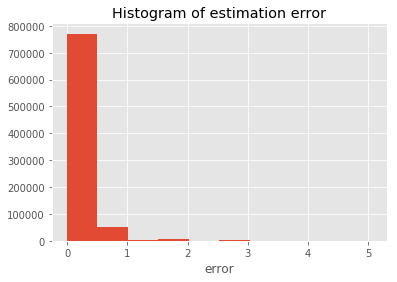

In [12]:
df_svd['err'].hist()
plt.xlabel("error")
plt.title("Histogram of estimation error");

### RMSE

In [13]:
from surprise import accuracy
accuracy.rmse(predictions_svd);

RMSE: 0.3653


### Recall

We define the **miss** as if the recipe error of $(true - estimation) > 0.05$.<br>
Since the rating feature actually represents the binary favor (like or not like), rather than measurement of some recipes.<br>
So the estimation is quite close, as you can see in the above figure, errors are mainly distributed in range $[0,\ 1]$.<br>
Therefore, we have to choose relatively small error to calculate **recall**, which means the number of the predicted most-like recipes over the number of true right recipes, i.e., $$\frac{TP}{TP + FN}$$ where $TP=true\ positive$ and $FN=false\ negative$

In [14]:
from collections import defaultdict
user_est_true = defaultdict(list)
for uid, _, true_r, est, _ in predictions_svd:
    user_est_true[uid].append((est, true_r))

In [15]:
ERROR_THRESHOLD = 0.05

In [16]:
recalls = {}
for uid, user_ratings in user_est_true.items():
    ratings = np.array(user_ratings)
    tp = ratings[:, 1]
    tp_num = tp.shape[0]
    
    fn = ratings[np.where((ratings[:, 1] - ratings[:, 0]) > ERROR_THRESHOLD)][:, 0]
    fn_num = fn.shape[0]
    recalls[uid] = tp_num / (tp_num + fn_num)

In [17]:
print(f"Recalls: {np.array(list(recalls.values())).mean():.4f}")

Recalls: 0.9238


## Prediction

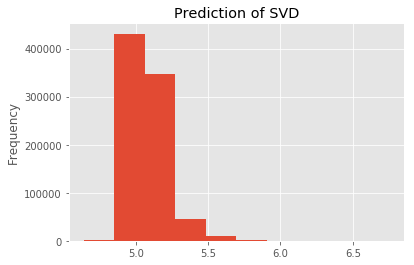

In [18]:
df_svd.estimation.plot(kind='hist', title='Prediction of SVD');

## Recommendations

In [19]:
import json
from collab_filter import top_k
from pathlib import Path

In [20]:
top_5 = top_k(predictions_svd, 5)
dictionary = json.load(Path("data/preprocessed/dictionary.json").open(encoding="utf-8"))

In [21]:
recipe_id_to_english = {ind: v for ind, (k, v) in enumerate(dictionary.items())}

In [22]:
def display_recommend(data, dictionary, ind=None):
    if ind is None:
        ind = np.random.randint(0, high=len(data))
    try:
        print(f"Recommendation for user [{ind}]")
        for recipe_id, rates in data[ind]:
            print(f"·{dictionary[recipe_id]}: {rates:.3f}")
    except KeyError:
        print(f"User {ind} doesn't exist.")

In [23]:
display_recommend(top_5, recipe_id_to_english)

Recommendation for user [189998]
·Scrambled Egg with Chicken Liver: 5.066
·Sautéed Chicken with Snow Peas: 5.026
·Roast Lamb Leg: 4.993


## *Appendix: Grid search*

In [24]:
from collab_filter import load_dataset
from surprise import SVD
from surprise.model_selection import GridSearchCV, KFold

In [25]:
def train_grid_search():
    data = load_dataset()
    param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005], 'reg_all' : [0.4, 0.6]}
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
    gs.fit(data)
    table = [[] for _ in range(len(gs.cv_results['params']))]
    for i in range(len(gs.cv_results['params'])):
        for key in gs.cv_results.keys():
            table[i].append(gs.cv_results[key][i])
    headers = gs.cv_results.keys()
    return pd.DataFrame(table, columns=headers, index=gs.cv_results["params"])

In [26]:
csv_path = Path("res/svd_grid_serach.csv")
if csv_path.exists():
    df = pd.read_csv(str(csv_path), index_col=0)
else:
    df = train_grid_search()
    df.to_csv(str(csv_path))

In [29]:
# Remove repeated columns for better 
pd.options.display.float_format = '{:.4f}'.format
df.index.rename('params', inplace=True)
df.drop([h for h in df.head() if h .startswith("param")], axis=1)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time
params,,,,,,,,,,,,,,,,
"{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4}",0.3644,0.3609,0.3628,0.3627,0.0014,6,0.1582,0.1577,0.1582,0.1580,0.0002,4,29.4713,0.0564,8.9317,0.0898
"{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.6}",0.3650,0.3614,0.3634,0.3633,0.0014,8,0.1593,0.1588,0.1594,0.1592,0.0003,7,28.8231,0.1532,8.8813,0.0402
"{'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.4}",0.3638,0.3603,0.3620,0.3620,0.0014,2,0.1573,0.1568,0.1581,0.1574,0.0005,1,29.3047,0.7659,9.3364,0.7014
"{'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.6}",0.3645,0.3609,0.3626,0.3627,0.0015,5,0.1587,0.1582,0.1595,0.1588,0.0005,6,29.8173,0.9193,9.6570,1.1730
"{'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.4}",0.3637,0.3601,0.3621,0.3620,0.0014,1,0.1581,0.1575,0.1580,0.1579,0.0002,3,56.7222,0.0553,9.3279,0.6558
"{'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.6}",0.3644,0.3608,0.3628,0.3626,0.0014,4,0.1594,0.1588,0.1594,0.1592,0.0003,8,56.8888,0.2027,8.9146,0.0008
"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",0.3641,0.3605,0.3623,0.3623,0.0015,3,0.1574,0.1570,0.1582,0.1575,0.0005,2,56.7971,0.1359,8.8146,0.0142
"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.6}",0.3647,0.3611,0.3629,0.3629,0.0015,7,0.1585,0.1581,0.1593,0.1586,0.0005,5,56.8352,0.1780,9.3248,0.6603
